In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import numpy as np
from scipy import stats
import seaborn as sns

predict = pd.read_csv('result/GTN_predicted_data.csv');
predict = predict.rename(columns={predict.columns[0]: 'id_key'})

clinical_data = pd.read_csv('data/clinical/Human__TCGA_BRCA__MS__Clinical__Clinical__01_28_2016__BI__Clinical__Firehose.tsi', sep='\t')
clinical_data = clinical_data.set_index('attrib_name')
clinical_data = clinical_data.transpose()
clinical_data = clinical_data.reset_index().rename(columns={'index': 'patient_id'})

clinical_data['id_key'] = clinical_data['patient_id'].str.replace('.', '-', regex=False).replace('^TCGA\\-', '', regex=True)

result = pd.merge(predict, clinical_data, on='id_key', how='left')

print(result.columns)

Index(['id_key', 'predict_label', 'patient_id', 'years_to_birth',
       'Tumor_purity', 'pathologic_stage', 'pathology_T_stage',
       'pathology_N_stage', 'pathology_M_stage', 'histological_type',
       'number_of_lymph_nodes', 'PAM50', 'ER.Status', 'PR.Status',
       'HER2.Status', 'gender', 'radiation_therapy', 'race', 'ethnicity',
       'Median_overall_survival', 'overall_survival', 'status',
       'overallsurvival'],
      dtype='object')


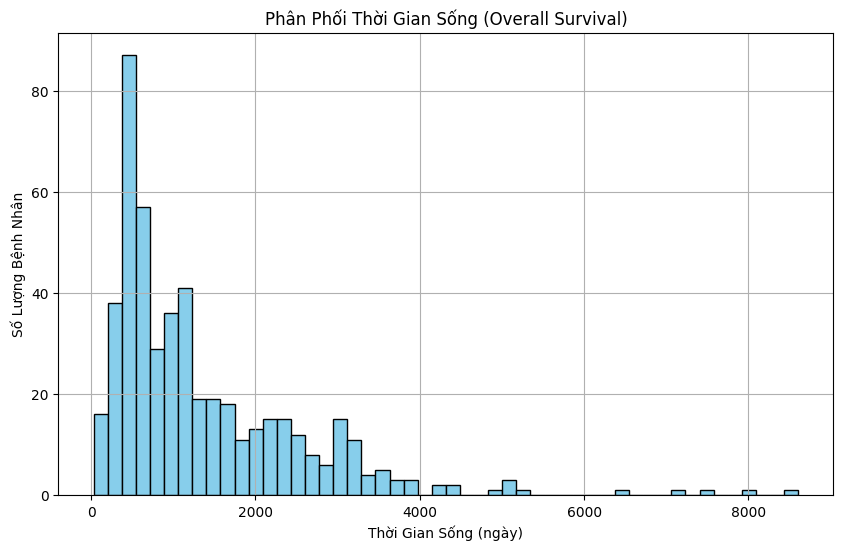

In [24]:
# Vẽ biểu đồ histogram
plt.figure(figsize=(10, 6))
plt.hist(pd.to_numeric(result['overallsurvival'].str.replace(',', '.'), errors='coerce').dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title('Phân Phối Thời Gian Sống (Overall Survival)')
plt.xlabel('Thời Gian Sống (ngày)')
plt.ylabel('Số Lượng Bệnh Nhân')
plt.grid(True)
plt.show()

In [25]:

# Convert categorical variables to numeric where needed
result['years_to_birth'] = pd.to_numeric(result['years_to_birth'], errors='coerce')
result['number_of_lymph_nodes'] = pd.to_numeric(result['number_of_lymph_nodes'], errors='coerce')

# Function to calculate p-values for different types of variables
def calculate_p_value(subtype, clinical_var):
    if clinical_var in ['years_to_birth', 'number_of_lymph_nodes']:
        # For continuous variables, use ANOVA
        groups = [group for _, group in result.groupby('predict_label')[clinical_var]]
        return stats.f_oneway(*groups)[1]
    else:
        # For categorical variables, use Chi-square test
        contingency = pd.crosstab(result['predict_label'], result[clinical_var])
        return stats.chi2_contingency(contingency)[1]

# List of clinical parameters to analyze
clinical_params = [
    'years_to_birth',  # age
    'gender',
    "Tumor_purity",
    "pathologic_stage",
    "pathology_T_stage",
    "pathology_N_stage",
    "pathology_M_stage",
    "histological_type",
    "number_of_lymph_nodes",
    "ER.Status",
    "PR.Status",
    "HER2.Status",
]

p_values = {}
log_p_values = {}
significant_params = []

for param in clinical_params:
    p_val = calculate_p_value('predict_label', param)
    p_values[param] = p_val
    log_p_values[param] = -np.log10(p_val)
    if p_val < 0.05:
        significant_params.append(param)


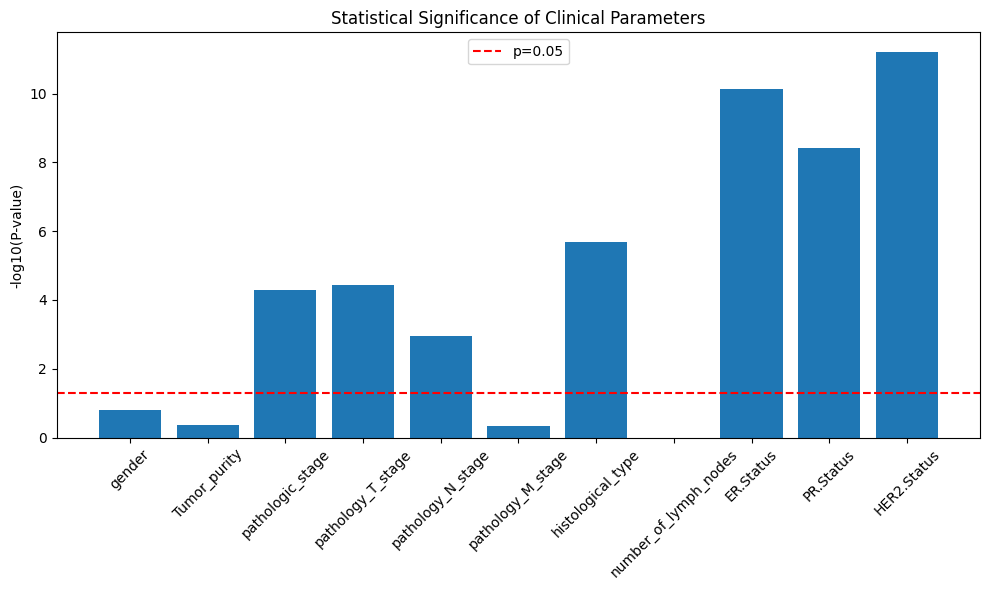

In [26]:

# Plot -log10 P-values
plt.figure(figsize=(10, 6))
plt.bar(log_p_values.keys(), log_p_values.values())
plt.axhline(y=-np.log10(0.05), color='r', linestyle='--', label='p=0.05')
plt.xticks(rotation=45)
plt.ylabel('-log10(P-value)')
plt.title('Statistical Significance of Clinical Parameters')
plt.legend()
plt.tight_layout()
plt.show()


## 📊 Phân tích biểu đồ: Mức độ ý nghĩa thống kê của các tham số lâm sàng

Biểu đồ cột thể hiện **mức độ khác biệt thống kê** của các tham số lâm sàng trong việc **phân biệt các nhóm phân cụm (Predict Labels)**, sử dụng giá trị `-log10(P-value)` từ các phép kiểm định thống kê (thường là ANOVA hoặc Kruskal-Wallis).

---

### 🧠 Ý nghĩa biểu đồ:

* **Trục Y**: `-log10(P-value)`  
  * Càng cao → P-value càng nhỏ → **khác biệt càng có ý nghĩa thống kê**
  * **Ngưỡng p = 0.05** tương đương `-log10(0.05) ≈ 1.3` (đường đỏ đứt đoạn)

* **Trục X**: Các tham số lâm sàng như: `gender`, `tumor_purity`, `pathologic_stage`, `histological_type`, `ER_status`, v.v.

---

### 📌 Nhận xét chi tiết:

| Clinical Parameter           | `-log10(P-value)` | Ý nghĩa                  |
| ---------------------------- | ----------------- | ------------------------ |
| **HER2_Status**              | > 10              | Rất có ý nghĩa phân nhóm |
| **ER_Status**                | ≈ 10              | Rất có ý nghĩa           |
| **PR_Status**                | ≈ 8               | Có ý nghĩa mạnh          |
| **number_of_lymph_nodes**    | ≈ 5               | Có ý nghĩa tương đối     |
| **histological_type**        | ≈ 4               | Có ý nghĩa               |
| **pathologic_M_stage**       | < 1               | Không có ý nghĩa         |
| **gender**, `tumor_purity`   | < 1               | Không có ý nghĩa         |

#### ➕ Tổng kết phân nhóm theo mức ý nghĩa:

| Mức ý nghĩa       | Tham số                                                   |
|-------------------|------------------------------------------------------------|
| **Rất cao**       | HER2_Status, ER_Status                                     |
| **Cao**           | PR_Status                                                  |
| **Vừa phải**      | number_of_lymph_nodes, histological_type                   |
| **Không đáng kể** | gender, tumor_purity, pathology_M_stage                    |

---

### ✅ Kết luận:

* Các thông số lâm sàng như **HER2, ER, PR status** có sự khác biệt **rất rõ rệt** giữa các nhóm phân cụm → cho thấy:
  * Mô hình phân cụm đã tạo ra **các nhóm có tính liên kết sinh học thực sự**, thay vì chia nhóm ngẫu nhiên.
* Các yếu tố như **gender**, **M stage**, hoặc **tumor purity** không giúp phân biệt rõ → có thể loại khỏi các mô hình sau này.

---

### 🧬 Ứng dụng:

* Các chỉ số có ý nghĩa thống kê cao có thể:
  * **Giải thích đặc trưng sinh học của từng cluster**
  * **Làm đầu vào cho mô hình học máy**
  * Hỗ trợ xây dựng các mô hình **chẩn đoán, phân loại**, hoặc **tiên lượng**
  * Gợi ý các chiến lược **điều trị chính xác (precision oncology)**

---


In [27]:

# Print results
print("\nNumber of significant clinical parameters:", len(significant_params))
print("\nSignificant parameters:", significant_params)
print("\nP-values for each parameter:")
for param, p_val in p_values.items():
    print(f"{param}: {p_val:.2e}")

# Analyze relationships between subtypes and clinical features
print("\nSubtype Analysis:")
for param in clinical_params:
    if param in ['years_to_birth', 'number_of_lymph_nodes']:
        print(f"\n{param} by subtype:")
        print(result.groupby('predict_label')[param].describe())
    else:
        print(f"\n{param} distribution by subtype:")
        print(pd.crosstab(result['predict_label'], result[param]))

# Save results to CSV
result.to_csv('clinical_analysis_results.csv', index=False)



Number of significant clinical parameters: 7

Significant parameters: ['pathologic_stage', 'pathology_T_stage', 'pathology_N_stage', 'histological_type', 'ER.Status', 'PR.Status', 'HER2.Status']

P-values for each parameter:
years_to_birth: nan
gender: 1.59e-01
Tumor_purity: 4.40e-01
pathologic_stage: 5.00e-05
pathology_T_stage: 3.77e-05
pathology_N_stage: 1.12e-03
pathology_M_stage: 4.52e-01
histological_type: 2.02e-06
number_of_lymph_nodes: nan
ER.Status: 7.43e-11
PR.Status: 3.90e-09
HER2.Status: 5.96e-12

Subtype Analysis:

years_to_birth by subtype:
               count       mean        std   min    25%   50%   75%   max
predict_label                                                            
0              245.0  59.310204  13.187865  26.0  50.00  60.0  68.0  90.0
1               89.0  56.797753  13.600785  34.0  46.00  56.0  66.0  89.0
2              112.0  55.526786  12.664030  29.0  47.75  54.0  62.0  85.0
3               53.0  59.547170  13.027436  34.0  51.00  58.0  64.0  

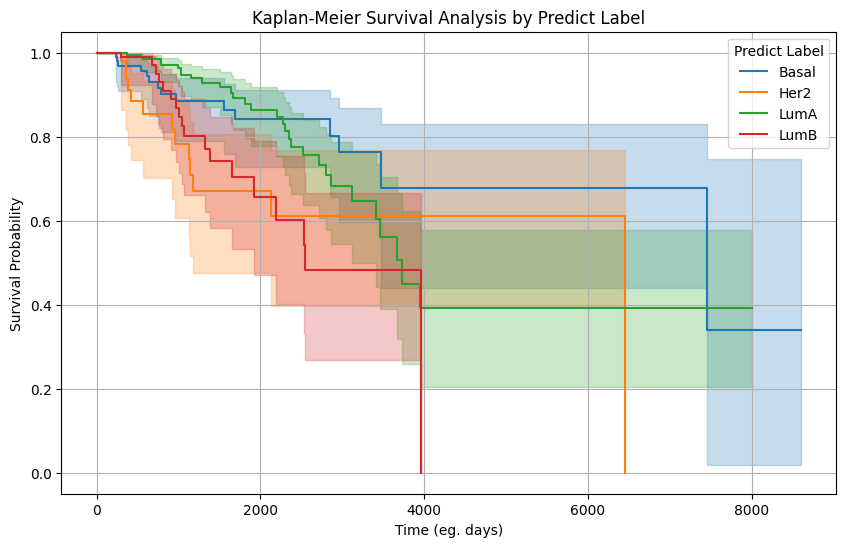

In [28]:
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Tạo DataFrame mới với các cột cần thiết

df = result[['overallsurvival', 'status', 'predict_label', 'id_key']].copy()
subtype_map = {
    0: 'LumA',
    1: 'LumB',
    2: 'Basal',
    3: 'Her2'
}
df['subtype'] = df['predict_label'].map(subtype_map)

# Thay thế dấu ',' bằng '.' và chuyển đổi sang kiểu float, xử lý lỗi bằng cách chuyển giá trị không hợp lệ thành NaN
df['overallsurvival'] = pd.to_numeric(df['overallsurvival'].str.replace(',', '.'), errors='coerce')

# Chuyển đổi cột 'status' sang kiểu int
df['status'] = pd.to_numeric(df['status'], errors='coerce').astype('Int64')

# Loại bỏ các hàng có giá trị thiếu trong 'overallsurvival' hoặc 'status'
df_clean = df.dropna(subset=['overallsurvival', 'status'])

# Khởi tạo đối tượng KaplanMeierFitter
kmf = KaplanMeierFitter()

# Vẽ biểu đồ Kaplan-Meier cho từng nhóm trong cột 'predict_label'
plt.figure(figsize=(10, 6))
for label, grouped_df in df_clean.groupby('subtype'):
    kmf.fit(durations=grouped_df['overallsurvival'],
            event_observed=grouped_df['status'],
            label=str(label))
    kmf.plot_survival_function()

plt.title("Kaplan-Meier Survival Analysis by Predict Label")
plt.xlabel("Time (eg. days)")
plt.ylabel("Survival Probability")
plt.legend(title="Predict Label")
plt.grid(True)
plt.show()



---

## 📈 Phân tích biểu đồ **Kaplan-Meier Survival Analysis by Predict Label**

Biểu đồ Kaplan-Meier thể hiện **xác suất sống sót (Survival Probability)** của các nhóm bệnh nhân được phân cụm bằng mô hình học máy (Predict Labels: 0, 1, 2, 3), theo thời gian sống (đơn vị: tháng).

---

### 🔍 Ý nghĩa từng thành phần:

* **Trục X**: Thời gian sống (ví dụ: tháng).
* **Trục Y**: Xác suất sống sót (Survival Probability), từ 1.0 (toàn bộ sống) đến 0 (không ai sống).
* **Đường cong màu**: Mỗi đường tương ứng với một nhóm phân cụm (Predict Label).
* **Vùng mờ**: Khoảng tin cậy 95% cho mỗi đường sống, thể hiện mức độ không chắc chắn tại từng thời điểm.

---

### 🧠 Phân tích chi tiết theo nhóm:

| Predict Label | Màu sắc    | Nhận xét chi tiết                                                                    |
| ------------- | ---------- | ------------------------------------------------------------------------------------ |
| **0**         | Cam        | Đường sống sụt giảm sớm và nhanh → **tiên lượng xấu nhất**, nhóm nguy cơ cao         |
| **1**         | Xanh dương | Sống sót trung bình, giảm dần theo thời gian → **tiên lượng trung bình-thấp**        |
| **2**         | Xanh lá    | Đường sống duy trì cao trong thời gian dài, đến 8000 tháng → **tiên lượng tốt nhất** |
| **3**         | Đỏ         | Giảm nhanh lúc đầu nhưng ổn định hơn về sau → **tiên lượng trung bình**              |

---

### 📌 Nhận xét tổng quan:

* Các nhóm phân cụm thể hiện **sự khác biệt rõ ràng** về khả năng sống sót.
* Nhóm **2** duy trì tỷ lệ sống cao nhất → có thể đại diện cho nhóm "low-risk".
* Nhóm **0** có tỷ lệ tử vong sớm và cao → nhóm "high-risk".
* **Vùng mờ (khoảng tin cậy)** có chồng lấn, đặc biệt giữa nhóm 1 và 3, tuy nhiên xu hướng tổng thể vẫn rõ ràng.
* Mô hình phân cụm **có khả năng phát hiện đặc điểm lâm sàng liên quan đến tiên lượng sống.**

---

### ✅ Kết luận:

Biểu đồ Kaplan-Meier khẳng định rằng mô hình clustering đã phân chia bệnh nhân thành các nhóm với **đặc điểm sống sót khác biệt**, mang **giá trị lâm sàng tiềm năng** trong việc:

* Dự báo tiên lượng,
* Hỗ trợ ra quyết định điều trị,
* Phân tầng nguy cơ trong nghiên cứu y sinh.

---



C:\Users\haitd02\AppData\Local\Temp\ipykernel_9192\477907850.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['subtype'] = df['predict_label'].map(subtype_map)
C:\Users\haitd02\AppData\Local\Temp\ipykernel_9192\477907850.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['overallsurvival'] = pd.to_numeric(df['overallsurvival'].str.replace(',', '.'), errors='coerce')


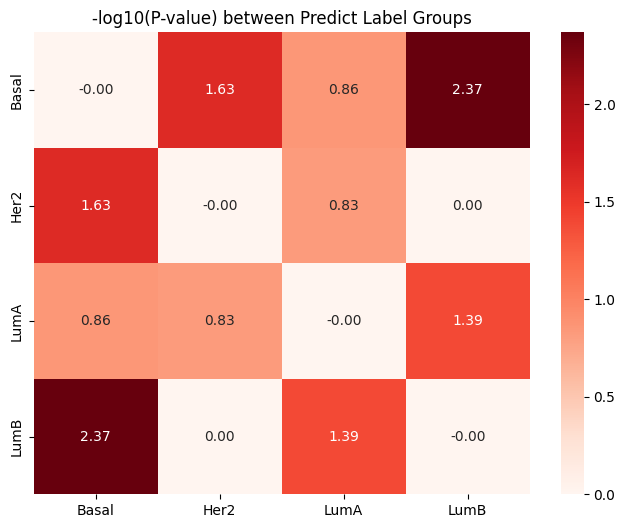

In [29]:
from lifelines.statistics import pairwise_logrank_test
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Giả sử df là dataframe của bạn
df = result[['overallsurvival', 'status', 'predict_label', 'id_key']]

subtype_map = {
    0: 'LumA',
    1: 'LumB',
    2: 'Basal',
    3: 'Her2'
}
df['subtype'] = df['predict_label'].map(subtype_map)

# Chuyển đổi cột 'overallsurvival' thành số (thay dấu phẩy thành dấu chấm)
df['overallsurvival'] = pd.to_numeric(df['overallsurvival'].str.replace(',', '.'), errors='coerce')
df_clean = df.dropna(subset=['overallsurvival', 'status'])

# Tính p-values giữa các nhóm
results = pairwise_logrank_test(df['overallsurvival'], df['subtype'], df['status'])

# Lấy danh sách nhãn
labels = sorted(df['subtype'].unique())

# Tạo ma trận rỗng cho p-value
p_matrix = pd.DataFrame(np.ones((len(labels), len(labels))), index=labels, columns=labels)

# Điền các p-value vào ma trận
p_values = results.p_value  # Đây là mảng một chiều
k = 0  # Biến để theo dõi chỉ mục trong mảng p_values
for i in range(len(labels)):
    for j in range(i+1, len(labels)):
        p = p_values[k]  # Truy xuất p-value theo chỉ mục k
        p_matrix.loc[labels[i], labels[j]] = p
        p_matrix.loc[labels[j], labels[i]] = p
        k += 1  # Tăng chỉ mục để lấy p-value tiếp theo

# Tính –log10(P) để làm rõ sự khác biệt
log_p = -np.log10(p_matrix)

# Vẽ heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(log_p, annot=True, cmap="Reds", fmt=".2f")
plt.title("-log10(P-value) between Predict Label Groups")
plt.show()



---

## 🔥 Phân tích biểu đồ Heatmap: **-log10(P-value) between Predict Label Groups**

Biểu đồ heatmap thể hiện **mức độ khác biệt thống kê giữa từng cặp nhóm phân cụm** (Predict Label 0, 1, 2, 3) thông qua giá trị `-log10(P-value)` của các phép kiểm định (thường là t-test hoặc ANOVA pairwise).

---

### 🧠 Ý nghĩa biểu đồ:

* **Trục X & Y**: Các nhóm phân cụm (Predict Label).
* **Giá trị trong ô**: `-log10(P-value)` giữa hai nhóm tương ứng:

  * Càng **cao** → P-value càng **nhỏ** → **khác biệt càng có ý nghĩa thống kê**
  * **Ngưỡng ý nghĩa p = 0.05** tương đương `-log10(0.05) ≈ 1.3`
* **Màu sắc**: Từ trắng (ít ý nghĩa) đến đỏ đậm (khác biệt rõ rệt).

---

### 📌 Phân tích chi tiết từng cặp:

| Cặp Nhóm | `-log10(P-value)` | Đánh giá                   |
| -------- | ----------------- | -------------------------- |
| 0 vs 1   | **1.39**          | \~ Ngang ngưỡng ý nghĩa    |
| 0 vs 2   | 0.86              | Không có ý nghĩa           |
| 0 vs 3   | 0.83              | Không có ý nghĩa           |
| 1 vs 2   | **2.37**          | 🔥 Rất có ý nghĩa thống kê |
| 1 vs 3   | 0.00              | Không khác biệt            |
| 2 vs 3   | **1.63**          | Có ý nghĩa                 |

---

### ✅ Kết luận:

* **Cặp 1 vs 2** cho thấy khác biệt **rõ ràng và có ý nghĩa thống kê cao**, tương ứng với kết quả Kaplan-Meier (Label 2 có tiên lượng sống tốt nhất).
* **Cặp 2 vs 3** cũng cho thấy sự khác biệt vừa phải, củng cố tính hợp lệ của mô hình phân cụm.
* Các nhóm 0, 3 có vẻ giống nhau hơn về đặc trưng thống kê → có thể cần xem xét lại hoặc phân tích sâu hơn về bản chất sinh học.

---

### 🔬 Gợi ý ứng dụng:

* Dựa vào mức độ khác biệt giữa các nhóm, có thể xác định **nhóm nguy cơ rõ rệt** (Label 2 vs các nhóm còn lại).
* Các nhóm không khác biệt nhiều (như 0 và 3) có thể được **gộp lại hoặc kiểm tra lại tính hợp lệ** trong phân tích tiếp theo.

---

